In [1]:

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint


In [2]:

from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input


In [3]:

img_width=256
img_height=256
batch_size=8

TRAINING_DIR = '../weather_pred/Data/training/'
VALIDATION_DIR = '../weather_pred/Data/validation/'

wp = '../vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
vgg16_base = VGG16(include_top=False, weights=wp,
                   input_tensor=None, 
                   input_shape=(img_height, img_width, 3))

In [4]:

TRAINING_DIR = '../weather_pred/Data/training/'

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=30,
                                   zoom_range=0.4,
                                   horizontal_flip=True
                                   )




In [5]:

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    target_size=(img_height, img_width))


Found 1274 images belonging to 5 classes.


In [6]:

VALIDATION_DIR = '../weather_pred/Data/validation/'

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              target_size=(img_height, img_width)
                                                             )


In [7]:

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              target_size=(img_height, img_width)
                                                             )


Found 226 images belonging to 5 classes.


In [12]:

callbacks = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')
best_model_file = '../vgg16_best_weights_256.h5'
best_model = ModelCheckpoint(best_model_file, monitor='val_acc', verbose = 1, save_best_only = True)
#reduce_lr = ReduceLROnPlateau(patience=5, monitor='val_acc', factor=0.1, min_lr=0.0000001, mode='auto', verbose=1)



In [13]:

wp = '../vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
vgg16_base = VGG16(include_top=False, weights=wp,
                   input_tensor=None, input_shape=(img_height, img_width, 3))


In [14]:

print('Adding new layers...')
output = vgg16_base.get_layer(index = -1).output  
output = Flatten()(output)
# let's add a fully-connected layer
output = Dense(1024,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.2)(output)
output = Dense(1024,activation = "relu")(output)
output = BatchNormalization()(output)
output = Dropout(0.2)(output)
output = Dense(5, activation='softmax')(output)
print('New layers added!')


Adding new layers...
New layers added!


In [15]:

vgg16_model = Model(vgg16_base.input, output)
for layer in vgg16_model.layers[:-7]:
    layer.trainable = False
vgg16_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [16]:

vgg16_model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics =['accuracy'])


In [17]:

history = vgg16_model.fit_generator(train_generator,
                              epochs=30,
                              verbose=1,
                              validation_data=validation_generator,
                              callbacks = [callbacks, best_model]
                              )


C:\Users\IT45\AppData\Local\Temp\ipykernel_5656\1577372558.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = vgg16_model.fit_generator(train_generator,


Epoch 1/30
160/160 [==============================] - 298s 2s/step - loss: 1.0422 - accuracy: 0.7543 - val_loss: 0.4251 - val_accuracy: 0.8805
Epoch 2/30
160/160 [==============================] - 296s 2s/step - loss: 0.6279 - accuracy: 0.8320 - val_loss: 0.5284 - val_accuracy: 0.8761
Epoch 3/30
160/160 [==============================] - 287s 2s/step - loss: 0.5420 - accuracy: 0.8407 - val_loss: 0.4317 - val_accuracy: 0.8850
Epoch 4/30
160/160 [==============================] - 239s 1s/step - loss: 0.3612 - accuracy: 0.8948 - val_loss: 0.2563 - val_accuracy: 0.9159
Epoch 5/30
160/160 [==============================] - 253s 2s/step - loss: 0.3730 - accuracy: 0.8909 - val_loss: 0.4524 - val_accuracy: 0.8496
Epoch 6/30
160/160 [==============================] - 271s 2s/step - loss: 0.3050 - accuracy: 0.9035 - val_loss: 0.2091 - val_accuracy: 0.9469
Epoch 7/30
160/160 [==============================] - 273s 2s/step - loss: 0.2658 - accuracy: 0.9066 - val_loss: 0.2592 - val_accuracy: 0.9292

In [19]:

target_dir = '../weather_pred/'
if not os.path.exists(target_dir):
  os.mkdir(target_dir)
vgg16_model.save(target_dir + 'vgg16_model_256.h5')
vgg16_model.save_weights(target_dir + 'vgg16_weights_256.h5')


In [22]:

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))


In [24]:
import matplotlib.pyplot as plt

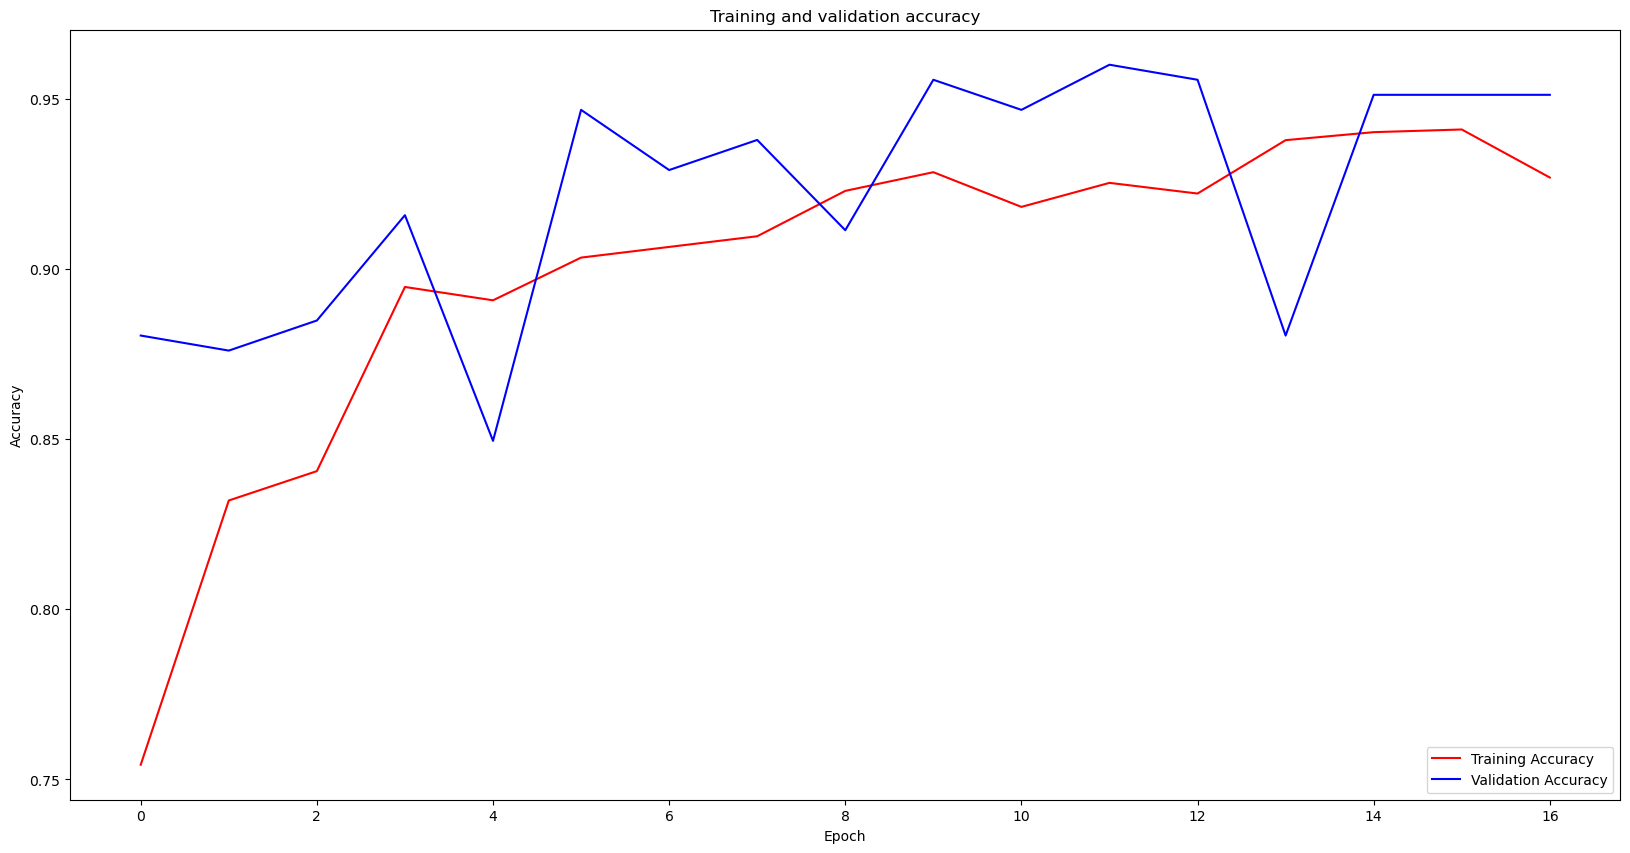

In [51]:

fig = plt.figure(figsize=(20,10))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()


Text(0.5, 1.0, 'Training and validation loss')

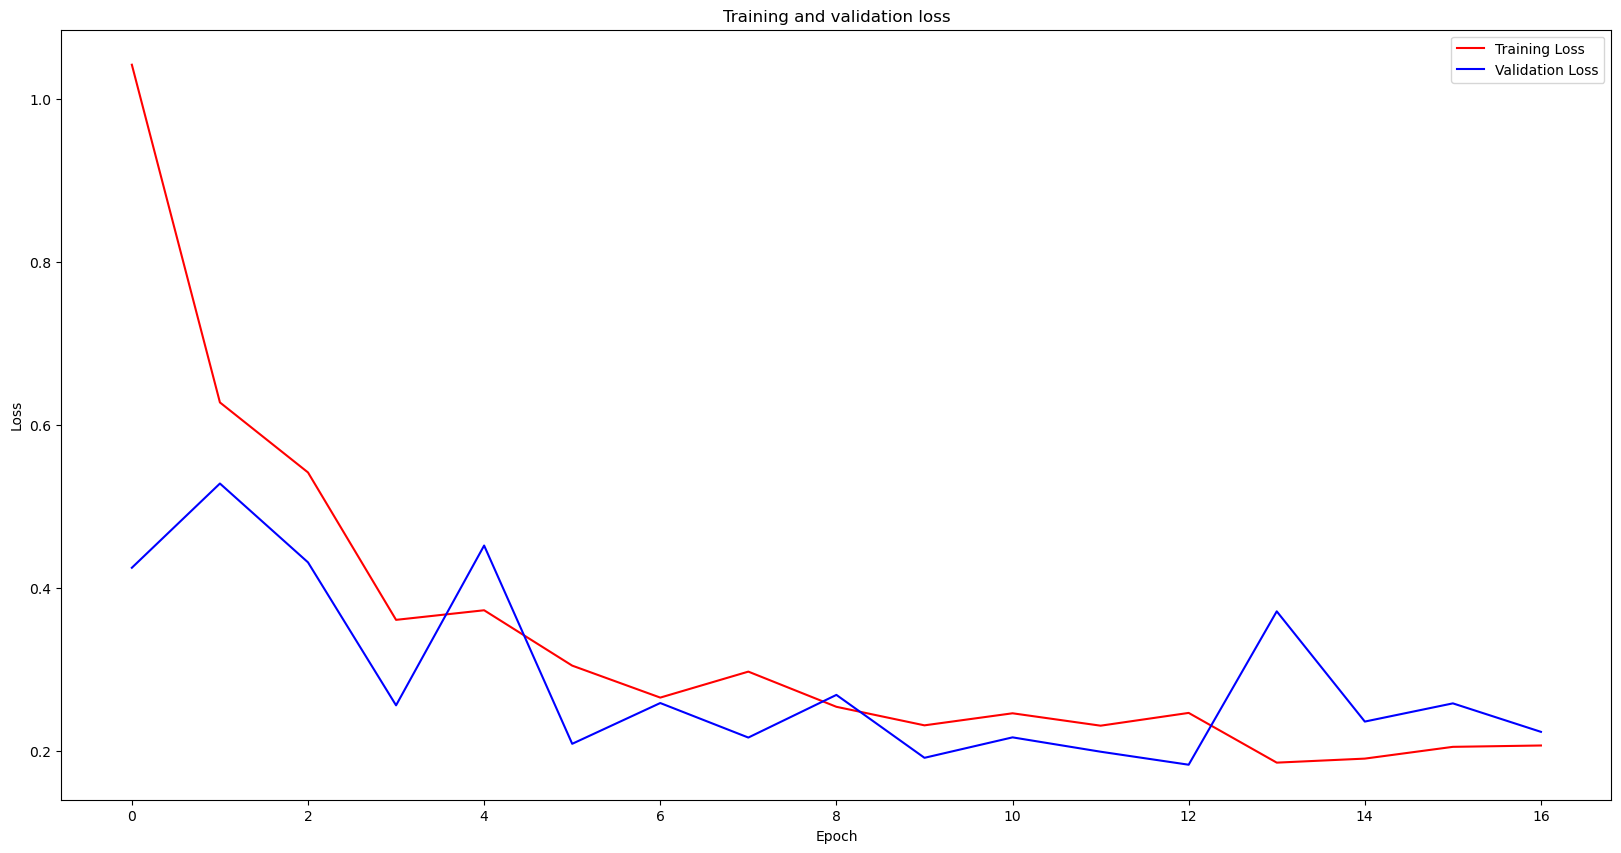

In [50]:

fig2 = plt.figure(figsize=(20,10))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')





Confusion matrix

In [27]:
import numpy as np, pandas as pd


In [28]:
test_preprocessed_images = np.load('../preprocessed_test_images/test_preproc_resnet.npy')

In [29]:
test_df = pd.read_csv('../dataset/test.csv')
y_true = test_df['labels']

In [32]:
array = vgg16_model.predict(test_preprocessed_images, batch_size=1, verbose=1)
y_pred = np.argmax(array, axis=1)

30/30 [==============================] - 9s 292ms/step


In [33]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_true, y_pred)

In [34]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = cm.round(2)
        #print("Normalized confusion matrix")
    else:
        cm=cm
        #print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [35]:
train_dir = '../weather_pred//Data/training/'
classes = os.listdir(train_dir)

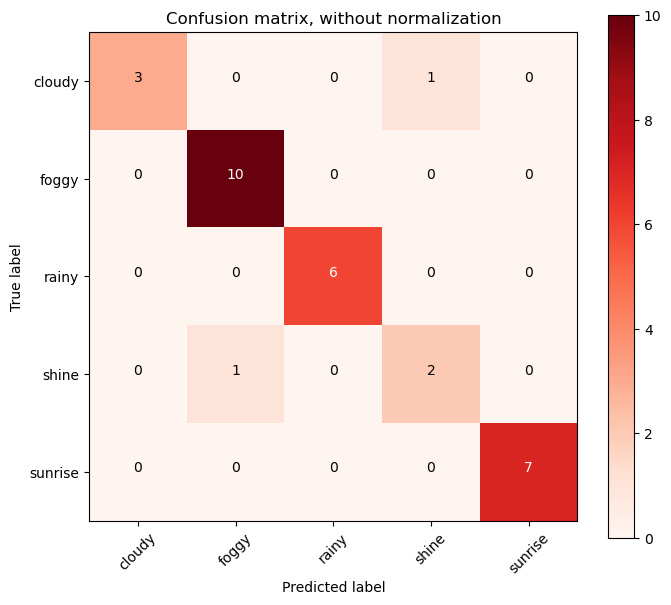

In [36]:
np.set_printoptions(precision=2)

fig1 = plt.figure(figsize=(7,6))
plot_confusion_matrix(conf_mat, classes=classes, title='Confusion matrix, without normalization')
#fig1.savefig('../cm_wo_norm.jpg')
plt.show()

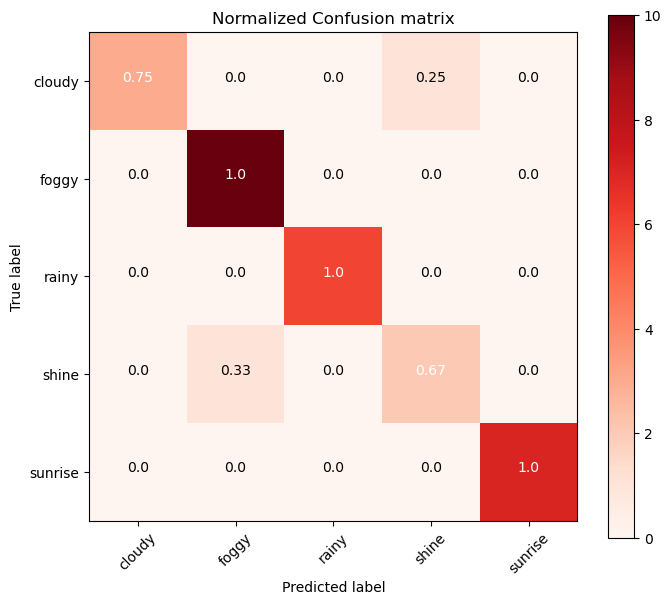

In [37]:
np.set_printoptions(precision=2)

fig2 = plt.figure(figsize=(7,6))
plot_confusion_matrix(conf_mat, classes=classes, normalize = True, title='Normalized Confusion matrix')
fig2.savefig('../cm_norm.jpg')
plt.show()

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [49]:
print("accuracy : ",accuracy_score(y_pred, y_true))
print("precision : " ,precision_score(y_pred, y_true, average="weighted"))
print("f1-score : ",f1_score(y_pred, y_true, average="weighted"))

accuracy :  0.9333333333333333
precision :  0.9416666666666667
f1-score :  0.9349206349206349
